# Experiment results

In [1]:
import yaml
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import re

from src.lib import plotting
importlib.reload(plotting)

cfg = plotting.get_config()

In [22]:
# os.listdir(cfg['experiment_directory'])

In [7]:
hist_baseline = plotting.load_hist("standard-scaler-baseline")
hist_baseline2 = plotting.load_hist("standard-scaling-no-time-1")
hist_min_max = plotting.load_hist("min-max-1")
hist_mixed_s1 = plotting.load_hist("mixed-preprocessing-test-1")
hist_mixed_s2 = plotting.load_hist("mixed-preprocessing-test-2")
hist_mixed_kl1 = plotting.load_hist("mixed-preprocessing-test-kl-9")
hist_mixed_kl2 = plotting.load_hist("mixed-preprocessing-test-kl-30")
hist_edain = plotting.load_hist("edain-preprocessing-1")

hist_nothing = plotting.load_hist("no-preprocess-1")

(0.2, 0.23)

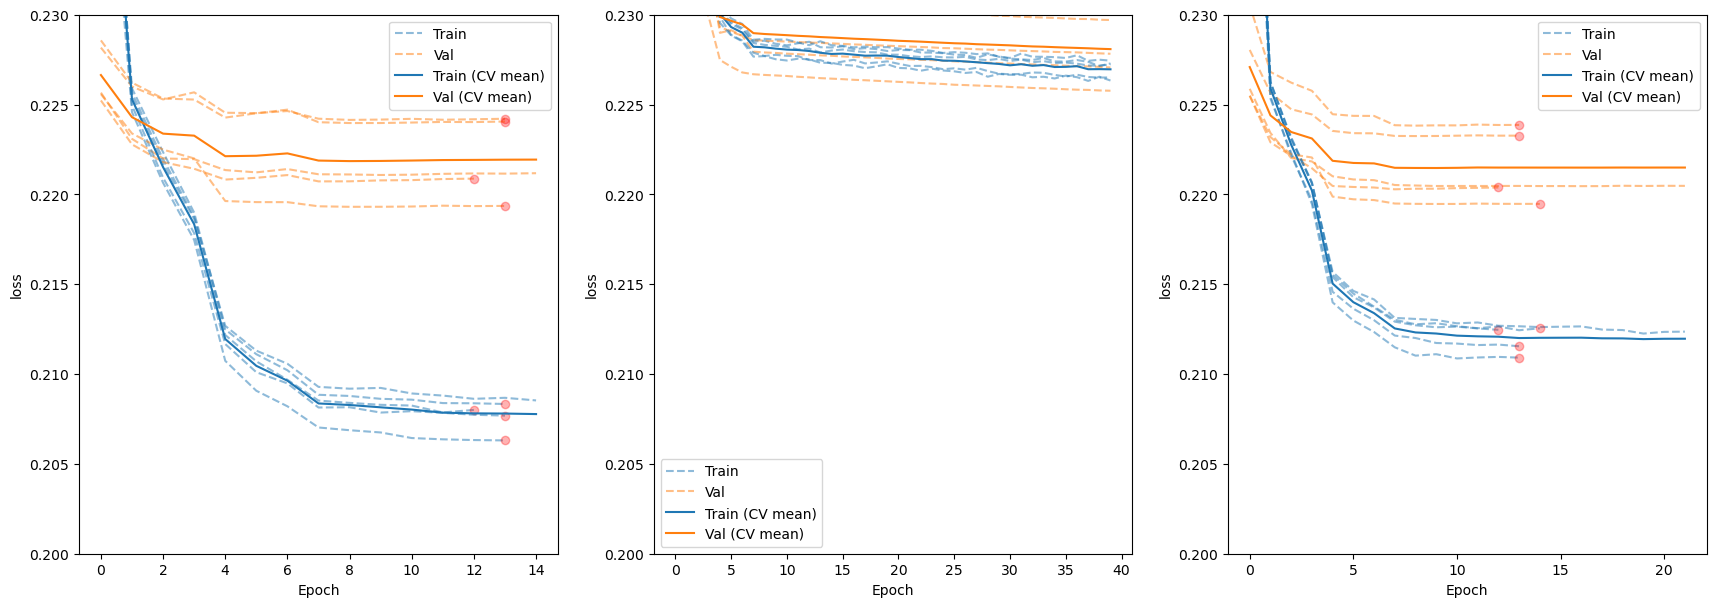

In [14]:
fig, axs = plt.subplots(ncols=3, figsize=(21, 7))
plotting.plot_cv(hist_baseline, "loss", axs[0])
plotting.plot_cv(hist_min_max, "loss", axs[1])
plotting.plot_cv(hist_mixed, "loss", axs[2])
axs[0].set_ylim([0.20, 0.23])
axs[1].set_ylim([0.20, 0.23])
axs[2].set_ylim([0.20, 0.23])

In [27]:
def compare_hists(histories, labels, key, ax, cols=None):
    if cols is None:
        cols = ['black', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'black', 'grey']
    assert len(histories) <= len(cols) and "Not enough colours specified"
    
    for hist, c, l in zip(histories, cols, labels):
        cv_avgs = plotting.get_average(hist, key)
        ax.plot(cv_avgs, label = f"{l} ({cv_avgs[-1]:.4f})", color=c, alpha=1)
        ax.plot(len(cv_avgs) - 1, cv_avgs[-1], marker='o', color=c)
    ax.legend(title=f"Preprocessing method ({key})")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(key)
    
def get_best_hist_cfg(exp_name):
    files = [f for f in os.listdir(cfg['experiment_directory']) if re.match(re.escape(exp_name) + r'-\d+.*', f)]
    best_vloss = float("inf")
    ret_hist = None
    for f in files:
        # remove the .npy ending
        hist = plotting.load_hist(f[:-4])
        if hist['val_loss'][0][-1] < best_vloss:
            best_vloss = hist['val_loss'][0][-1]
            ret_hist = hist
    return ret_hist

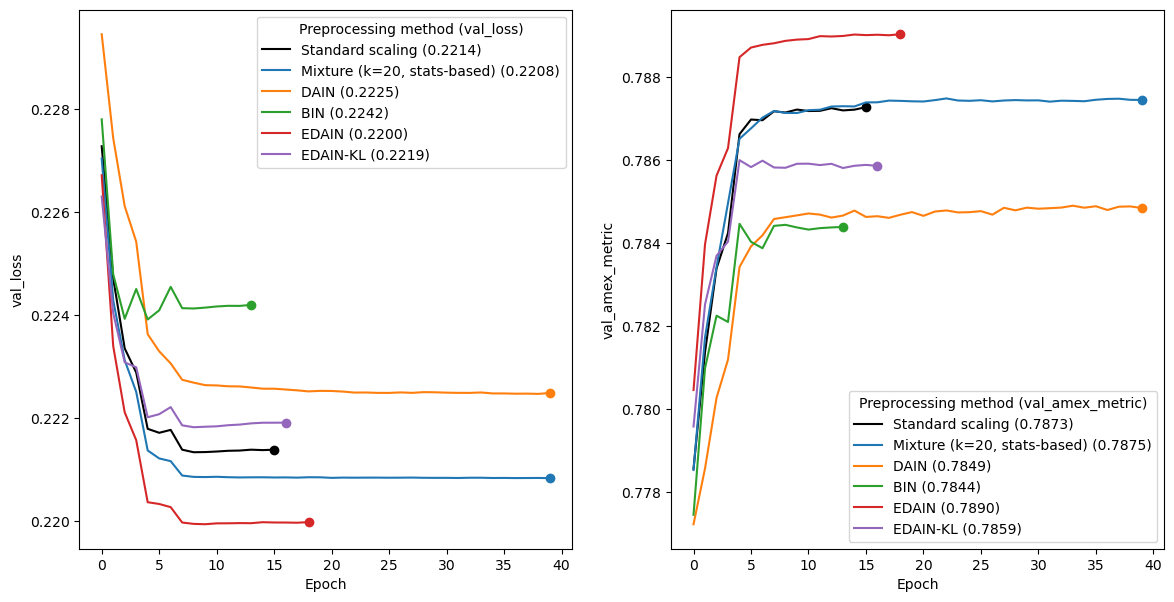

In [28]:
hist_ss = plotting.load_hist("standard-scaling-no-time-1")
hist_mixed = plotting.load_hist("mixture-clustering-tuning-5")
hist_edain = plotting.load_hist("edain-preprocessing-1")
hist_dain = plotting.load_hist("amex-dain-preprocessing-1")
hist_bin = plotting.load_hist("amex-bin-preprocessing-1")
hist_edain_kl = plotting.load_hist("amex-edain-kl-preprocessing-1")

fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
compare_hists(
    [hist_ss, hist_mixed, hist_dain, hist_bin, hist_edain, hist_edain_kl],
    ["Standard scaling", "Mixture (k=20, stats-based)", "DAIN", "BIN", "EDAIN", "EDAIN-KL"],
    "val_loss",
    axs[0])
compare_hists(
    [hist_ss, hist_mixed, hist_dain, hist_bin, hist_edain, hist_edain_kl],
    ["Standard scaling", "Mixture (k=20, stats-based)", "DAIN", "BIN", "EDAIN", "EDAIN-KL"],
    "val_amex_metric",
    axs[1])

## Learning rate tuning for Amex dataset

In [7]:
def get_best_hist_cfg(exp_name):
    files = [f for f in os.listdir(cfg['experiment_directory']) if re.match(re.escape(exp_name) + r'-\d+.*', f)]
    best_vloss = float("inf")
    ret_hist = None
    for f in files:
        # remove the .npy ending
        hist = plotting.load_hist(f[:-4])
        if hist['val_loss'][0][-1] < best_vloss:
            best_vloss = hist['val_loss'][0][-1]
            ret_hist = hist
    return ret_hist

# optimal DAIN parameters
hist = get_best_hist_cfg("dain-tuning")
print(hist['experiment_config']['dain'])
print(f"Final validation loss: {hist['val_loss'][0][-1]:.4f}")
hist['cli_arguments']

{'mode': 'adaptive_scale', 'mean_lr': 1.0, 'scale_lr': 1.0, 'gate_lr': 0.001, 'input_dim': 177}
Final validation loss: 0.2216


{'experiment_config': 'src/experiments/configs/experiment-config-alpha.yaml',
 'device': '0',
 'mixture_device_ids': None,
 'dataset': 'amex',
 'model': 'gru-rnn',
 'adaptive_layer': 'dain',
 'preprocessing_method': 'standard-scaler',
 'edain_kl': False,
 'winsorize': False,
 'ignore_time': False,
 'num_cross_validation_folds': 1,
 'random_state': 42,
 'experiment_name': 'dain-tuning-7',
 'override': 'dain:mean_lr:1 dain:scale_lr:1 fit:num_epochs:10'}

In [19]:
# optimal BiN parameters
hist = get_best_hist_cfg("bin-tuning")
print(hist['experiment_config']['bin'])
print(f"Final validation loss: {hist['val_loss'][0][-1]:.4f}")

{'beta_lr': 10.0, 'gamma_lr': 1.0, 'lambda_lr': 1e-06, 'base_lr': 0.001}
Final validation loss: 0.2234


In [11]:
# optimal EDAIN-KL parameters
hist = get_best_hist_cfg("edain-kl-tuning")
print(hist['experiment_config']['edain_bijector_fit'])
print(f"Final validation loss: {hist['val_loss'][0][-1]:.4f}")

{'batch_size': 1024, 'milestones': [3, 7], 'num_epochs': 20, 'num_fits': 1, 'base_lr': 0.001, 'scale_lr': 10.0, 'shift_lr': 10.0, 'outlier_lr': 100.0, 'power_lr': 1e-07, 'device': device(type='cuda', index=0)}
Final validation loss: 0.2208


## Learning rate tuning for LOB dataset

In [2]:
def get_best_hist_cfg(exp_name):
    files = [f for f in os.listdir(cfg['experiment_directory']) if re.match(re.escape(exp_name) + r'-\d+.*', f)]
    best_kappa = float("-inf")
    ret_hist = None
    for f in files:
        # remove the .npy ending
        hist = plotting.load_hist(f[:-4])
        kappa = np.max([v['kappa'] for v in hist['split_results'][0]])
        if kappa > best_kappa:
            best_kappa = kappa
            ret_hist = hist
    return ret_hist

hist = get_best_hist_cfg('edain-ba-lob-tuning')
hist['experiment_config']['edain_bijector_fit'], np.max([v['kappa'] for v in hist['split_results'][0]])

({'batch_size': 1024,
  'milestones': [3, 7],
  'num_epochs': 20,
  'num_fits': 1,
  'base_lr': 0.001,
  'scale_lr': 0.0001,
  'shift_lr': 0.01,
  'outlier_lr': 10.0,
  'power_lr': 10.0},
 0.3859274668367296)

In [3]:
hist = get_best_hist_cfg('edain-non-batch-aware-lob-tuning')
hist['experiment_config']['edain_bijector_fit'], np.max([v['kappa'] for v in hist['split_results'][0]])

({'batch_size': 1024,
  'milestones': [3, 7],
  'num_epochs': 20,
  'num_fits': 1,
  'base_lr': 0.001,
  'scale_lr': 10.0,
  'shift_lr': 10.0,
  'outlier_lr': 1e-06,
  'power_lr': 0.001},
 0.27876875819556557)

In [4]:
hist = get_best_hist_cfg('bin-lob-tuning') # TODO: rerun this cell once tune experiment done
hist['experiment_config']['bin'], np.max([v['kappa'] for v in hist['split_results'][0]])

({'beta_lr': 1.0, 'gamma_lr': 1e-08, 'lambda_lr': 0.1, 'base_lr': 0.0001},
 0.3287380876761202)

In [3]:
hist = get_best_hist_cfg('edain-kl-lob-tuning')
hist['experiment_config']['edain_bijector_fit'], np.max([v['kappa'] for v in hist['split_results'][0]])

({'batch_size': 1024,
  'milestones': [3, 7],
  'num_epochs': 20,
  'num_fits': 1,
  'base_lr': 0.001,
  'scale_lr': 0.0001,
  'shift_lr': 0.01,
  'outlier_lr': 10.0,
  'power_lr': 0.001,
  'device': device(type='cuda', index=0)},
 0.27565945318441754)

## Comparing number of clusters for mixture

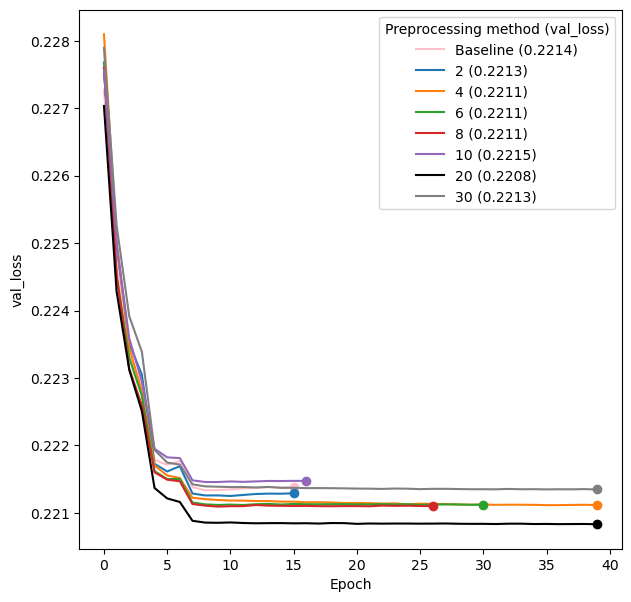

In [9]:
num_clusters = [2, 4, 6, 8, 10, 20, 30]

histories = []
for i in range(len(num_clusters)):
    histories.append(plotting.load_hist(f"mixture-clustering-tuning-{i}"))

fig, ax = plt.subplots(figsize=(7, 7))
compare_hists([hist_baseline2] + histories, ["Baseline"] + num_clusters, "val_loss", ax)

## LOB FI-2010 results

In [4]:
import string

def get_exp_names():
    files = [f for f in os.listdir(cfg['experiment_directory'])]
    exp_names = []
    for f in files:
        n = f[:-4].rstrip(string.digits)
        if n[-1] == '-':
            n = n[:-1]
        exp_names.append(n)

    return sorted(list(set(exp_names)))
get_exp_names()

['LOB-BIN-experiment-final',
 'LOB-DAIN-experiment-final',
 'LOB-EDAIN-experiment-final-v',
 'LOB-EDAIN-global-experiment-final-v',
 'LOB-min-max-experiment-final',
 'LOB-standard-scaling-experiment-final',
 'amex-bin-preprocessing',
 'amex-dain-preprocessing',
 'amex-edain-kl-preprocessing',
 'amex-edain-preprocessing-1-changed',
 'bin-lob-tuning',
 'bin-tuning',
 'dain-tuning',
 'edain-ba-lob-tuning',
 'edain-batch-aware-tuning-test',
 'edain-kl-lob-tuning',
 'edain-kl-tuning',
 'edain-non-batch-aware-lob-tuning',
 'edain-preprocessing',
 'edain-preprocessing-no-time',
 'edain-test',
 'edain-tuning',
 'edain-tuning-baseline',
 'edain-tuning-test',
 'lob-bin-experiment',
 'lob-bin-tuning-test',
 'lob-dain-experiment',
 'lob-edain-experiment',
 'lob-edain-experiment-batch-aware',
 'lob-standard-scaler-experiment',
 'lob-test-tuning',
 'min-max',
 'mixed-preprocessing-test',
 'mixed-preprocessing-test-kl',
 'mixture-clustering-tuning',
 'new-refactor-test-test',
 'no-preprocess',
 'stan

In [12]:
!ls /home/silo1/mas322/experiment-results-2/*lob*

/home/silo1/mas322/experiment-results-2/lob-bin-experiment-2.npy
/home/silo1/mas322/experiment-results-2/lob-bin-experiment.npy
/home/silo1/mas322/experiment-results-2/lob-bin-tuning-test.npy
/home/silo1/mas322/experiment-results-2/lob-dain-experiment-2.npy
/home/silo1/mas322/experiment-results-2/lob-dain-experiment.npy
/home/silo1/mas322/experiment-results-2/lob-edain-experiment-2.npy
/home/silo1/mas322/experiment-results-2/lob-edain-experiment-batch-aware-2.npy
/home/silo1/mas322/experiment-results-2/lob-standard-scaler-experiment-2.npy
/home/silo1/mas322/experiment-results-2/lob-standard-scaler-experiment.npy
/home/silo1/mas322/experiment-results-2/lob-test-tuning.npy


In [34]:
import pandas as pd

hist_bin = plotting.load_hist("lob-bin-experiment-2")
hist_dain = plotting.load_hist("lob-dain-experiment-2")
hist_edain = plotting.load_hist("lob-edain-experiment-2")
hist_edain_ba = plotting.load_hist("lob-edain-experiment-batch-aware-2")
hist_ss = plotting.load_hist("lob-standard-scaler-experiment-2")

hist_bin = plotting.load_hist('LOB-BIN-experiment-final')
hist_dain = plotting.load_hist('LOB-DAIN-experiment-final')
hist_edain_ba = plotting.load_hist('LOB-EDAIN-experiment-final-v1')
hist_min_max = plotting.load_hist('LOB-min-max-experiment-final')
hist_ss = plotting.load_hist('LOB-standard-scaling-experiment-final')

histories = [hist_ss, hist_bin, hist_dain, hist_edain, hist_edain_ba]
hist_names = ["Standard scaling", "BIN", "DAIN", "EDAIN", "EDAIN (batch aware)"]

def get_ci(hist, key):
    vals = []
    for i in range(len(hist['split_results'])):
        vs = [v[key] for v in hist['split_results'][i]]
        vals.append(np.max(vs)) # to revert to previous version, take last value instead
    return vals #np.mean(vals), 1.96 * np.std(vals)

print("Method              KAPPA")
for hist, n in zip(histories, hist_names):
    vals = get_ci(hist, "kappa")
    m, s = np.mean(vals), 1.96 * np.std(vals)
    print(f"{n}{' ' * (20 - len(n))}{m:.4f} +- {s:.4f}")

print("")
print("Method              F1-score avg")
for hist, n in zip(histories, hist_names):
    vals = get_ci(hist, "f1_avg")
    m, s = np.mean(vals), 1.96 * np.std(vals)
    print(f"{n}{' ' * (20 - len(n))}{m:.4f} +- {s:.4f}")

Method              KAPPA
Standard scaling    0.2780 +- 0.0555
BIN                 0.3670 +- 0.0640
DAIN                0.3610 +- 0.0474
EDAIN               0.2771 +- 0.0629
EDAIN (batch aware) 0.3837 +- 0.0554

Method              F1-score avg
Standard scaling    0.5076 +- 0.0408
BIN                 0.5889 +- 0.0479
DAIN                0.5803 +- 0.0324
EDAIN               0.5061 +- 0.0485
EDAIN (batch aware) 0.5953 +- 0.0418


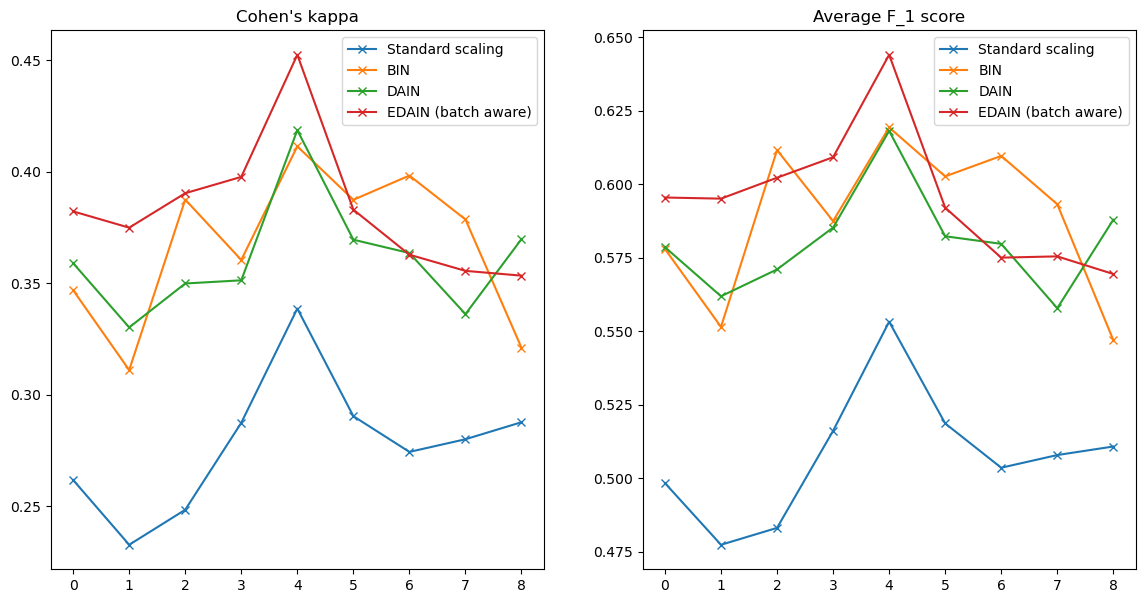

In [36]:
histories = [hist_ss, hist_bin, hist_dain, hist_edain_ba]
hist_names = ["Standard scaling", "BIN", "DAIN", "EDAIN (batch aware)"]

fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
for hist, n in zip(histories, hist_names):
    vals = get_ci(hist, "kappa")
    axs[0].plot(vals, label=n, marker="x")
axs[0].legend()
axs[0].set_title("Cohen's kappa")
for hist, n in zip(histories, hist_names):
    vals = get_ci(hist, "f1_avg")
    axs[1].plot(vals, label=n, marker="x")
axs[1].legend()
axs[1].set_title("Average F_1 score")
plt.show()

## LOB FI-2010 dataset

In [102]:
hist = plotting.load_hist("lob-test-tuning")
hist['split_results'][0][0].keys()

dict_keys(['accuracy', 'precision', 'recall', 'f1', 'precision_avg', 'recall_avg', 'f1_avg', 'kappa', 'val_loss', 'train_loss'])

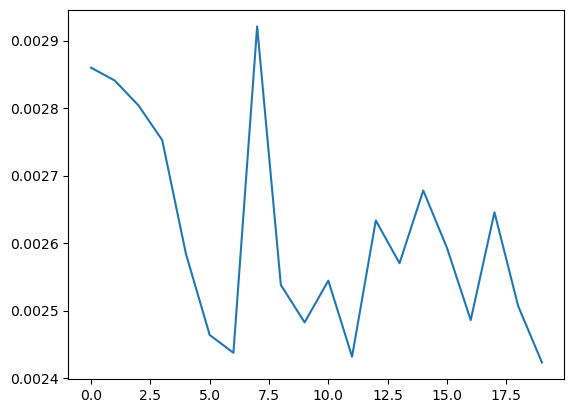

In [45]:
# This is a plot of the training loss with base_lr=1e-5 and milestone lr step at epoch 6
plt.plot([x['train_loss'] for x in hist['split_results'][0]])

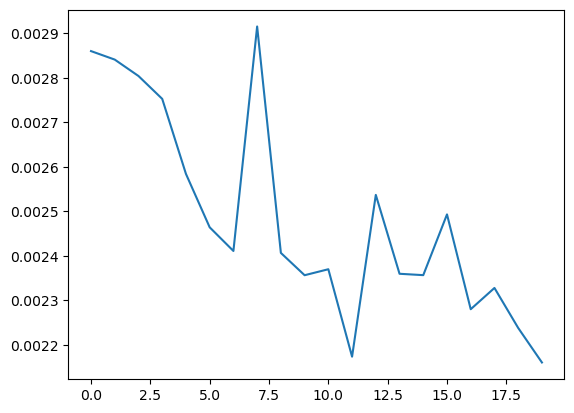

In [47]:
# This is a plot of the training loss with base_lr=1e-5 and no scheduling...
plt.plot([x['train_loss'] for x in hist['split_results'][0]])

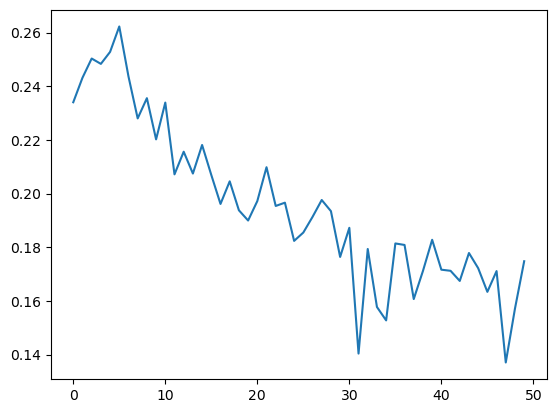

In [59]:
plt.plot([x['kappa'] for x in hist['split_results'][0]])

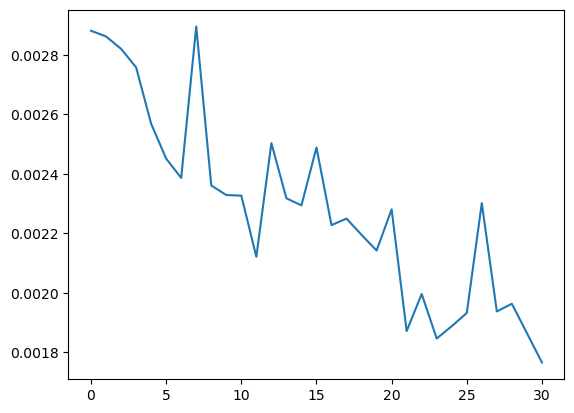

In [64]:
plt.plot([x['train_loss'] for x in hist['split_results'][0]])

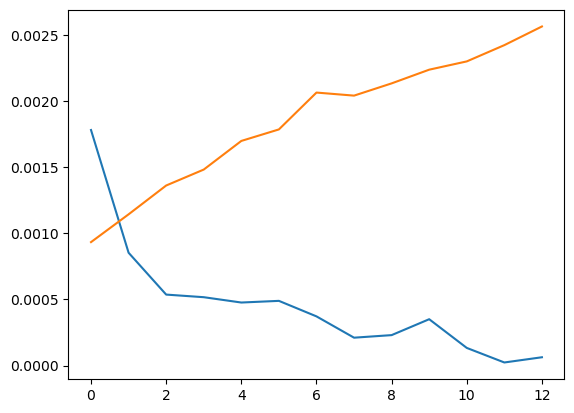

In [72]:
# using lr=1e-3 with steps at 10 and 20
plt.plot([x['train_loss'] for x in hist['split_results'][0]])
plt.plot([x['val_loss'] / 1024 for x in hist['split_results'][0]])

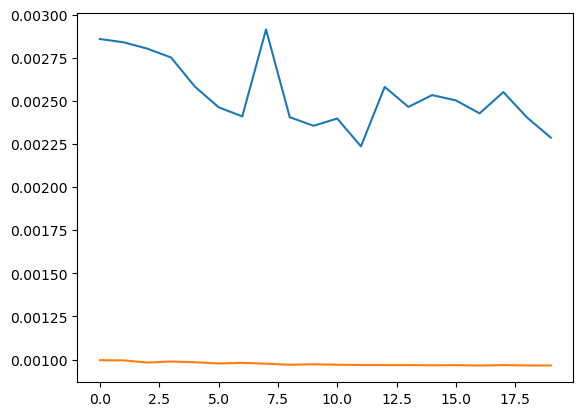

In [83]:
plt.plot([x['train_loss'] for x in hist['split_results'][0]])
plt.plot([x['val_loss'] / 1024 for x in hist['split_results'][0]])

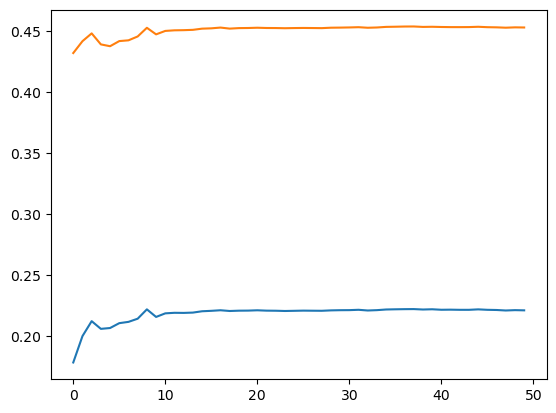

In [87]:
# This is using Adam optimizer, with base_lr 1e-5 and steps at 10 and 20
#   and also not using any early stopping
plt.plot([x['kappa'] for x in hist['split_results'][0]])
plt.plot([x['f1_avg'] for x in hist['split_results'][0]])
#plt.plot([x['val_loss'] / 1024 for x in hist['split_results'][0]])

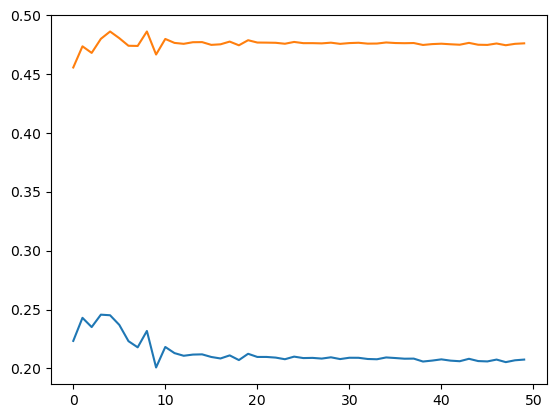

In [89]:
# This is using Adam optimizer, with base_lr 1e-4 and steps at 10 and 20
#   and also not using any early stopping
plt.plot([x['kappa'] for x in hist['split_results'][0]])
plt.plot([x['f1_avg'] for x in hist['split_results'][0]])
#plt.plot([x['val_loss'] / 1024 for x in hist['split_results'][0]])

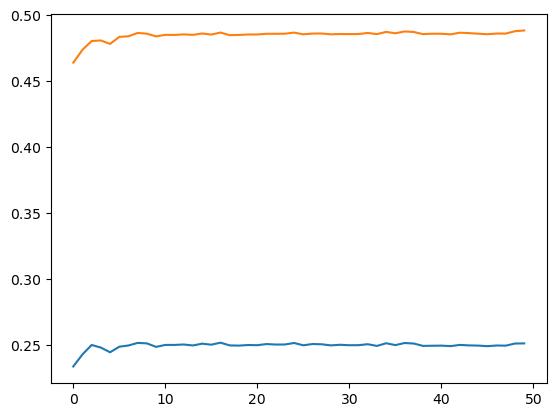

In [103]:
# using rmsprop with milestones 4 and 8, early stopping and lr=1e-4
plt.plot([x['kappa'] for x in hist['split_results'][0]])
plt.plot([x['f1_avg'] for x in hist['split_results'][0]])

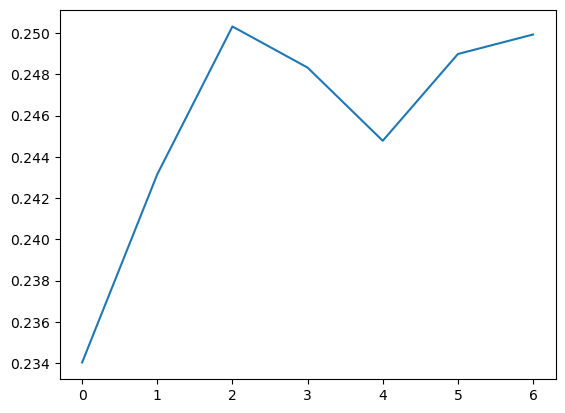

In [101]:
plt.plot([x['kappa'] for x in hist['split_results'][0]])
#plt.plot([x['f1_avg'] for x in hist['split_results'][0]])

In [75]:
hist_bin = plotting.load_hist("lob-bin-experiment")
hist_dain = plotting.load_hist("lob-dain-experiment")
hist_baseline = plotting.load_hist("lob-standard-scaler-experiment")
hist_baseline['split_results'][0][0].keys()

dict_keys(['accuracy', 'precision', 'recall', 'f1', 'precision_avg', 'recall_avg', 'f1_avg', 'kappa', 'val_loss', 'train_loss'])

In [79]:
def get_res(hist, key):
    vals = []
    for i in range(len(hist['split_results'])):
        vals.append(hist['split_results'][i][-1][key])
    return f"{np.mean(vals):.4f} +- {1.96 * np.std(vals):.4f}"
    
get_res(hist_bin, "f1_avg"), get_res(hist_dain, "f1_avg"), get_res(hist_baseline, "f1_avg")

('0.5441 +- 0.0425', '0.5574 +- 0.0332', '0.5021 +- 0.0416')

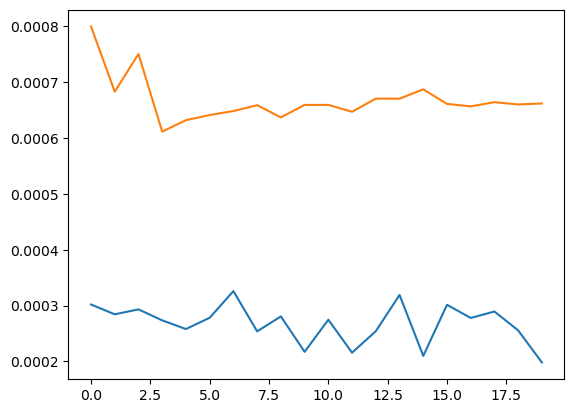

In [81]:
plt.plot([x['train_loss'] for x in hist_dain['split_results'][6]])
plt.plot([x['val_loss'] / 1024 for x in hist_dain['split_results'][6]])